In [1037]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as sps
import math

## Задача №1


![Image](1.jpg) 

## Задача №2

![Image](2.png) 

Можно, например, так: 

1. Считаем $\alpha_i -$отклонение от $\mu$, вызванное влиянием
2. Считаем $\beta_j -$отклонение от $\mu+\alpha_i$, вызванное влиянием особенностей $j$-го уровня фактора $A$
3. Считаем ошибки $\varepsilon_{ij} = X_{ij} - \mu - \alpha_i - \beta_j$
4. Теперь основное. Для величин $\varepsilon_{ij}$
*  Строим QQ-plot и проверяем, что график близок к линейному
*  Применяем тест Колмогорова-Смирнова
*  Применяем тест Шапиро-Уилка
*  Проверяем, что $skewness \approx 0$
*  Проверяем, что $kurtosis \approx 0$

В зависимости от желаемых точностей делаем вывод о нормальности ошибок

## Задача №3

In [1038]:
drugs = pd.read_csv('hw7t3.txt', sep=',', header=None)
drugs = pd.DataFrame(drugs)
drugs[0] = (drugs[0].apply(lambda s: s[4:-1]))
drugs[1] = drugs[1].apply(lambda s: s[3:-1])
drugs[2] = drugs[2].apply(lambda s: s[:-1])
drugs[2][len(drugs)-1] = 0
drugs[2] = drugs[2].astype(int)
drugs = drugs.drop(columns=3)
drugs = drugs.rename(columns={0: 'Name', 1: 'Drug', 2: 'Effect'})
drugs.tail()
drugs.tail()

,Name,Drug,Effect
146,Gospodin Tsay,Permetrine,15
147,Gospodin Tsay,Permetrine,27
148,Gospodin Tsay,Permetrine,19
149,Gospodin Tsay,Permetrine,11
150,Gospodin Tsay,Permetrine,0


Названия препаратов и количество их использований

In [1039]:
drugs['Drug'].value_counts()

Analgine      30
Iodomarine    29
Mildronate    24
Permetrine    24
Codeine       23
Irunine       21
Name: Drug, dtype: int64

In [1040]:
drugnames = pd.unique(drugs['Drug'])
drugnames

array(['Mildronate', 'Codeine', 'Analgine', 'Iodomarine', 'Irunine',
       'Permetrine'], dtype=object)

Распределение эффекта по лекарствам

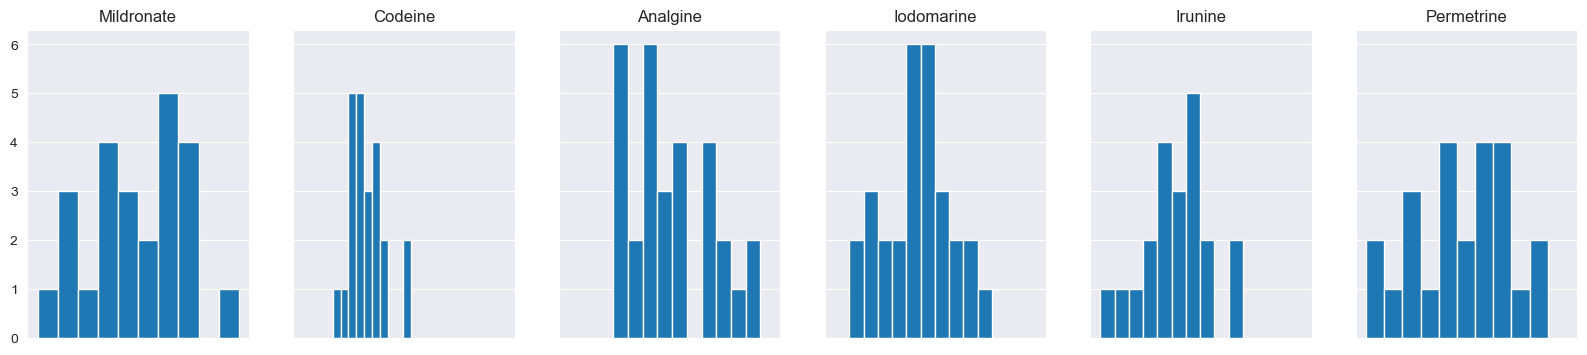

In [1041]:
fig, axes = plt.subplots(ncols=6, figsize=(20, 4), sharey=True, sharex=True)
for _ in range(6):
    axes[_].set_title(drugnames[_])
    axes[_].hist(drugs[drugs['Drug'] == drugnames[_]]['Effect'])
    
frame = plt.gca()
frame.axes.get_xaxis().set_ticks([]);

Из гистограмм сложно судить о нормальности данных

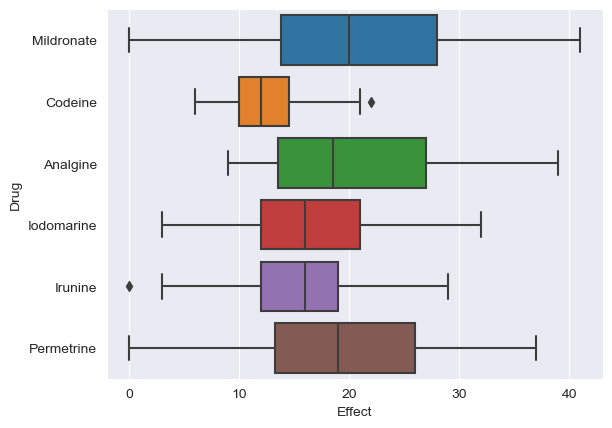

In [1042]:
sns.boxplot(y="Drug", x="Effect", data=drugs, orient="h");

boxplot распределения эффекта по людям

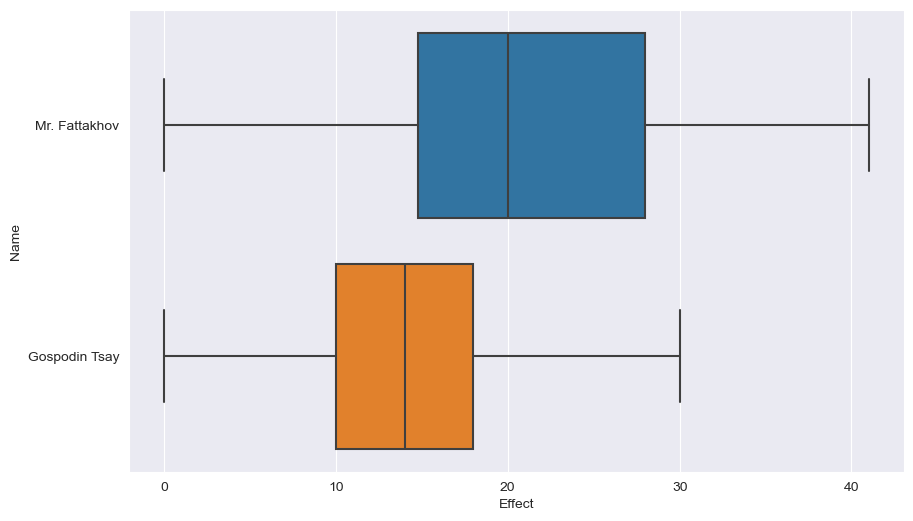

In [1043]:
plt.figure(figsize=(10, 6))
sns.boxplot(y="Name", x="Effect", data=drugs, orient="h");

Из графика можно судить, что эффект на Fattakhov выше чем на Tsay

In [1044]:
drugs.pivot_table(
    index="Drug", 
    columns="Name", 
    values="Effect", 
    aggfunc=lambda x: " ".join(map(str, x))
)

Name,Gospodin Tsay,Mr. Fattakhov
Drug,,
Analgine,11 9 16 16 21 15 23 12 11 17 27 18 13 10,28 35 31 29 38 23 20 39 19 30 9 27 23 17 11 15
Codeine,10 12 11 10 6 10 11 9,13 16 10 15 16 13 14 14 10 15 21 12 12 13 22
Iodomarine,23 16 8 5 22 8 19 11 3 11 29 21 18 16 24 15,19 20 16 6 15 28 24 16 20 18 12 14 32
Irunine,0 14 18 19 14 6 21 9 16 12 3,18 20 19 29 27 13 21 16 11 17
Mildronate,30 19 13 27 19 8 15 7 10 16 7 17,0 28 24 32 30 28 26 14 21 28 41 29
Permetrine,17 14 0 11 17 15 27 19 11 0,18 26 23 19 9 23 25 23 35 30 5 26 37 29


Перейдём к средним (по выборке в каждой ячейке)

In [1045]:
pivot = drugs.pivot_table(index="Name", columns="Drug", values="Effect", aggfunc=lambda x: x.mean())
pivot

Drug,Analgine,Codeine,Iodomarine,Irunine,Mildronate,Permetrine
Name,,,,,,
Gospodin Tsay,15.642857,9.875,15.562500,12.0,15.666667,13.100000
Mr. Fattakhov,24.625000,14.400,18.461538,19.1,25.083333,23.428571


Критерий Фридмана (мешающий фактор человека затираем):

In [1046]:
sps.friedmanchisquare(*np.array(pivot).T)

FriedmanchisquareResult(statistic=9.142857142857139, pvalue=0.10349995148362036)

Делаем вывод, что есть эффект от лекарства (какого-то)

Проверим однофакторным критерием Краскела-Уоллиса значимость фактора человека

In [1047]:
sps.kruskal(*[drugs[drugs['Name'] == name]['Effect'].values for name in drugs['Name']])

KruskalResult(statistic=1821.0703577729241, pvalue=1.1608349552803221e-284)

Делаем вывод, что эффекта фактора человека нет.

### Перейдём к проверке попарных упорядоченных равенств против альтернатив(>) с помощью критерия LSD Фишера

Проверим нормальность:

In [1048]:
for sample in [drugs[drugs['Drug'] == drug]['Effect'].values for drug in drugnames]:
    print(sps.normaltest(sample))

NormaltestResult(statistic=0.25642587486881896, pvalue=0.8796660453693268)
NormaltestResult(statistic=5.733909500485668, pvalue=0.05687185213936877)
NormaltestResult(statistic=2.4306378623425253, pvalue=0.2966153993102969)
NormaltestResult(statistic=0.02104811221448163, pvalue=0.9895311280146443)
NormaltestResult(statistic=0.8131901768883695, pvalue=0.6659137719009048)
NormaltestResult(statistic=0.41539878466937874, pvalue=0.812451229074203)


Проверим равенство дисперсий

Критерий Бартлетта

In [1049]:
sps.bartlett(*[drugs[drugs['Drug'] == drug]['Effect'].values for drug in drugnames])

BartlettResult(statistic=23.207913445513892, pvalue=0.00030802770066539354)

Критерий Левина

In [1050]:
sps.levene(*[drugs[drugs['Drug'] == drug]['Effect'].values for drug in drugnames], center='mean')

LeveneResult(statistic=4.7462564214200755, pvalue=0.0004793151628536492)

Критерий Флайнера-Киллиана

In [1051]:
sps.fligner(*[drugs[drugs['Drug'] == drug]['Effect'].values for drug in drugnames])

FlignerResult(statistic=19.920386574297478, pvalue=0.0012934567498142171)

Каждый из критериев отклонил гипотезу равенства дисперсий

Видим, что объёмы выборок разные, хотя и несильно отличаются, так что можем считать их равными

In [1052]:
for dr in [drugs[drugs['Drug'] == drug]['Effect'].values for drug in drugnames]:
    print(len(dr))

24
23
30
29
21
24


Применить однофакторный критерий Фишера

In [1053]:
sps.f_oneway(*[drugs[drugs['Drug'] == drug]['Effect'].values for drug in drugnames])

F_onewayResult(statistic=3.4492042716869196, pvalue=0.005643006932348378)

Отклоняем гипотезу об отсутствии различий лекарств

Критерий Краскела-Уоллиса

In [1054]:
sps.kruskal(*[drugs[drugs['Drug'] == drug]['Effect'].values for drug in drugnames])

KruskalResult(statistic=16.819139105874562, pvalue=0.004855889586154284)

Отклоняем гипотезу об отсутствии сдвига

### LSD Фишера

In [1055]:
dr_names_sorted = drugs.groupby('Drug')['Effect'].mean().sort_values().index
samples = [drugs[drugs['Drug'] == drug]['Effect'].values for drug in dr_names_sorted]

alpha = 0.05
k = 5
for j in range(k-1):
    nj = len(samples[j])
    njj = len(samples[j + 1])
    LSD = sps.t.ppf(
        1 - alpha * 0.5, 
        nj + njj - 2
    ) * math.sqrt(
        (nj + njj) / (nj * njj)
    ) * math.sqrt(
        (
                (nj - 1) * samples[j].var(ddof=False) + (njj - 1) * samples[j + 1].var(ddof=False)
        ) / (nj + njj - 2)
    )
    print("{} with {}: Diff = {}, LSD = {}".format(dr_names_sorted[j], dr_names_sorted[j + 1],
                                                   abs(samples[j].mean() - samples[j + 1].mean()), LSD))

Codeine with Irunine: Diff = 2.554865424430643, LSD = 3.3090218971328214
Irunine with Iodomarine: Diff = 1.4811165845648606, LSD = 4.025103388302702
Iodomarine with Permetrine: Diff = 2.262931034482758, LSD = 4.611116495383917
Permetrine with Mildronate: Diff = 1.25, LSD = 5.63761139677588


Критерий Шеффе для попарных сравнений

In [1056]:
def sheffe(c, samples):
    ns = np.array([len(x) for x in samples])
    k = len(samples)
    n = np.array(ns).sum()
    sin = 1. / (n - k) * (ns * np.array([x.var() for x in samples])).sum()
    S = (c * np.array([x.mean() for x in samples])).sum() ** 2 / ((k - 1) * sin * (c ** 2 / ns).sum())
    return S

u = sps.f.ppf(1-alpha, len(drugnames) - 1, len(drugs["Drug"].to_list()) - 1)

print("Квантиль распределения Фишера: {}\n".format(u))

for i in range(6):
    for j in range(i+1, 6):
        c = np.zeros(6)
        c[i] = 1
        c[j] = -1
        print("sheffe for {} and {} is {}".format(dr_names_sorted[i],
                                                  dr_names_sorted[j], sheffe(c, samples)))

Квантиль распределения Фишера: 2.2744909986071264

sheffe for Codeine and Irunine is 0.2198548069839077
sheffe for Codeine and Iodomarine is 0.6411009006830637
sheffe for Codeine and Permetrine is 1.4298085810540453
sheffe for Codeine and Mildronate is 2.053598406742723
sheffe for Codeine and Analgine is 2.311711527635855
sheffe for Irunine and Iodomarine is 0.08198440168778875
sheffe for Irunine and Permetrine is 0.4817327847129326
sheffe for Irunine and Mildronate is 0.8570947488958734
sheffe for Irunine and Analgine is 0.9675379426235532
sheffe for Iodomarine and Permetrine is 0.2063390660708223
sheffe for Iodomarine and Mildronate is 0.4972537547787464
sheffe for Iodomarine and Analgine is 0.5770543187899176
sheffe for Permetrine and Mildronate is 0.05753163619970142
sheffe for Permetrine and Analgine is 0.0700294963301946
sheffe for Mildronate and Analgine is 0.00013921235426100703


## Задача №4

In [1057]:
data = pd.DataFrame(data=np.load('hw7t4.npy'), columns=["A", "B", "Effect"])
data.head(5)

,A,B,Effect
0,0.0,0.0,1.038829
1,0.0,0.0,2.842808
2,0.0,0.0,0.890729
3,0.0,0.0,2.176776
4,0.0,0.0,0.915229


In [1058]:
data['A'] = data['A'].astype(int)
data['B'] = data['B'].astype(int)
data

,A,B,Effect
0,0,0,1.038829
1,0,0,2.842808
2,0,0,0.890729
3,0,0,2.176776
4,0,0,0.915229
...,...,...,...
245,4,4,2.135321
246,4,4,2.309004
247,4,4,1.431228
248,4,4,3.223043


Количество записей уровней каждого из факторов

In [1059]:
data['A'].value_counts()

0    50
1    50
2    50
3    50
4    50
Name: A, dtype: int64

In [1060]:
data['B'].value_counts()

0    50
1    50
2    50
3    50
4    50
Name: B, dtype: int64

Распределение эффекта по уровням фактора A

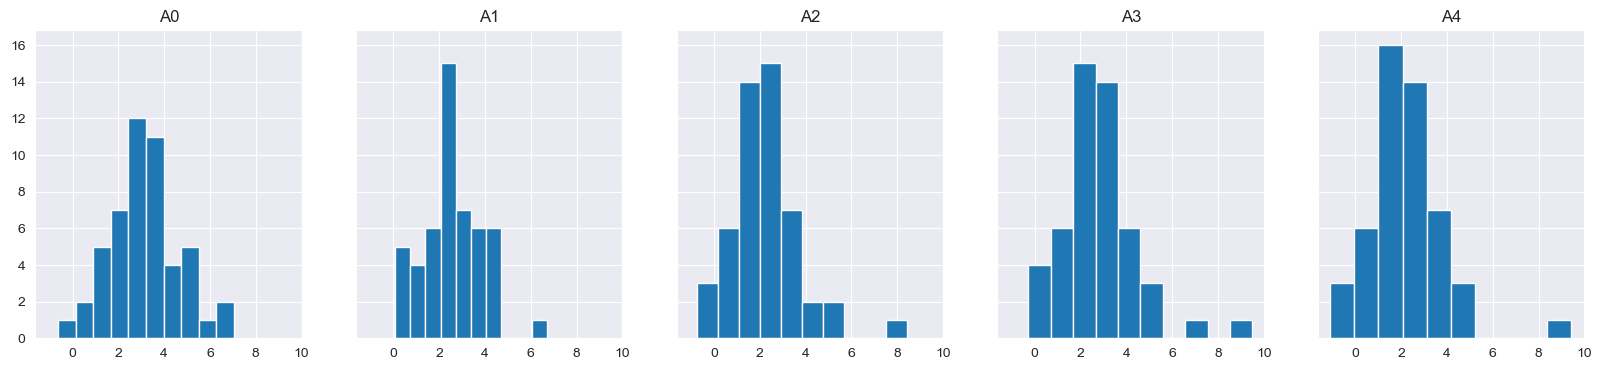

In [1061]:
fig, axes = plt.subplots(ncols = 5, figsize = (20, 4), sharey = True, sharex=True)
for _ in range(5):
    axes[_].set_title('A' + str(_))
    axes[_].hist(data[data['A'] == _]['Effect'])

Распределение эффекта по уровням фактора B

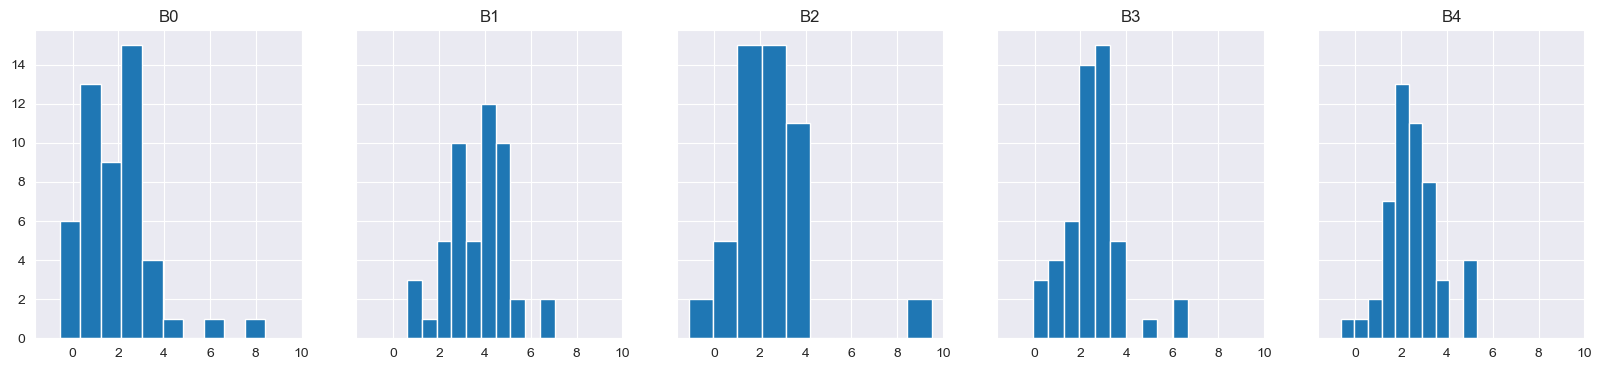

In [1062]:
fig, axes = plt.subplots(ncols = 5, figsize = (20, 4), sharey = True, sharex=True)
for _ in range(5):
    axes[_].set_title('B' + str(_))
    axes[_].hist(data[data['B'] == _]['Effect'])

Из гистограмм делаем выбор в пользу нормальности данных

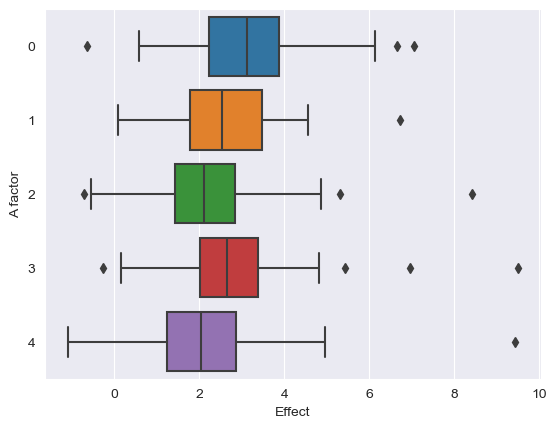

In [1063]:
sns.boxplot(y="A", x="Effect", data=data, orient="h")
plt.ylabel("A factor");

Эффекты разных уровней фактора A слабо отличаются

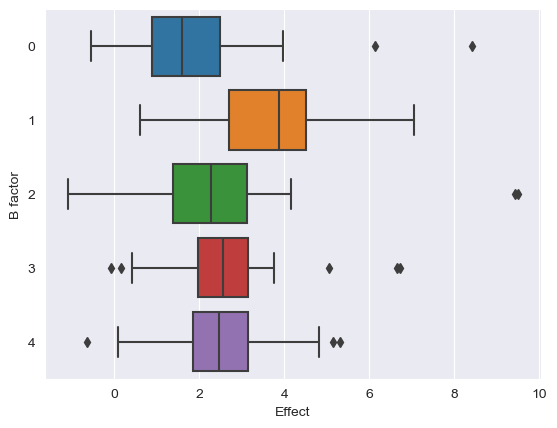

In [1064]:
import seaborn as sns
sns.boxplot(y="B", x="Effect", data=data, orient="h")
plt.ylabel("B factor");

Но вот с фактором B видим, что эффект уровня 1 прочих попарно приблизительно равных

In [1065]:
Table = data.pivot_table(
    index="A", 
    columns="B", 
    values="Effect", 
    aggfunc=lambda x: " ".join(map(str, x))
).rename(columns={0.0: 'B0', 1.0: 'B1', 2.0: 'B2', 3.0: 'B3', 4.0: 'B4'}).rename(index={0.0: 'A0', 1.0: 'A1', 2.0: 'A2', 3.0: 'A3', 4.0: 'A4'})
Table

B,B0,B1,B2,B3,B4
A,,,,,
A0,1.0388293792711492 2.8428084577191624 0.890729...,5.492530522149031 3.755297379990835 5.05660558...,3.1664803050145904 3.215713263505831 1.3207405...,2.1922617555831074 6.64394318891565 5.04185062...,2.84571705724833 5.152928954105238 0.581172719...
A1,0.38863690103493737 1.6524412537823012 2.43300...,4.063548439198704 2.7601880579798737 4.5113833...,2.543279237759836 3.2241604919530547 2.1421191...,1.79340808188274 2.1048355235386578 2.18829618...,1.5876062505902304 2.2872271684767886 1.777233...
A2,2.674969572173219 8.41334986129022 2.224616130...,4.0429182223038636 2.373404245077144 1.9704757...,1.4711498652498871 4.14864898174988 3.60304592...,1.7549956503470243 3.2824890309737653 2.869216...,2.5782578787815043 2.534207219926411 5.2961491...
A3,3.904357174035316 -0.274250003978498 1.3171385...,2.679903752296922 4.442800948239688 3.38189667...,9.506096956316204 3.0059394665798393 2.2755538...,2.5983789857140236 0.15057144125973065 1.17687...,2.3662721797581545 4.037387297320269 3.4208621...
A4,-0.3537804762356464 -0.44578194947196786 1.105...,4.179720750196331 4.178025969588383 2.82590875...,-1.1006670312897733 2.863275135762401 0.914422...,2.6527697416084255 2.1271739796223232 2.184085...,3.1629837978049804 1.6512858862101232 1.995590...


Перейдём к средним (по выборке в каждой ячейке)

In [1066]:
pivot = data.pivot_table(index="A", columns="B", values="Effect", aggfunc=lambda x: x.mean()).rename(columns={0.0: 'B0', 1.0: 'B1', 2.0: 'B2', 3.0: 'B3', 4.0: 'B4'}).rename(index={0.0: 'A0', 1.0: 'A1', 2.0: 'A2', 3.0: 'A3', 4.0: 'A4'})
pivot

B,B0,B1,B2,B3,B4
A,,,,,
A0,2.297883,4.618818,2.686027,3.564102,2.732624
A1,1.743740,3.948304,2.506460,2.565978,2.206595
A2,2.190384,2.965886,1.697775,1.904213,2.129998
A3,2.061388,3.855195,3.066496,2.136982,3.085336
A4,0.920877,2.970678,2.120465,2.446218,2.372401


Критерий Фридмана (мешающий фактор A затираем)

In [1067]:
sps.friedmanchisquare(*np.array(pivot).T)

FriedmanchisquareResult(statistic=13.280000000000001, pvalue=0.009985688142909994)

Делаем вывод, что есть эффект от уровня фактора B (какого-то)

In [1068]:
sps.friedmanchisquare(*np.array(pivot))

FriedmanchisquareResult(statistic=11.040000000000006, pvalue=0.02611812858242946)

Проверим однофакторным критерием Краскела-Уоллиса значимость фактора A

In [1069]:
sps.kruskal(*[data[data['A'] == x]['Effect'].values for x in pd.unique(data['A'])])

KruskalResult(statistic=20.170456733067795, pvalue=0.0004621528292803324)

Делаем вывод, что эффекта фактора человека нет

### Перейдём к проверке попарных упорядоченных равенств против альтернатив(>) с помощью критерия LSD Фишера

Проверим нормальность:

In [1070]:
for sample in [data[data['A'] == x]['Effect'].values for x in pd.unique(data['A'])]:
    print(sps.normaltest(sample))

NormaltestResult(statistic=0.6767824490016914, pvalue=0.7129163230002784)
NormaltestResult(statistic=2.4162613300654012, pvalue=0.2987552313685375)
NormaltestResult(statistic=22.232036411204497, pvalue=1.4872179981183609e-05)
NormaltestResult(statistic=26.414483695344508, pvalue=1.8372478354730704e-06)
NormaltestResult(statistic=32.92958160946825, pvalue=7.070208280387878e-08)


Проверим равенство дисперсий

Критерий Бартлетта

In [1071]:
sps.bartlett(*[data[data['B'] == x]['Effect'].values for x in pd.unique(data['B'])])

BartlettResult(statistic=13.112822049822787, pvalue=0.010737481875934013)

Критерий Левина

In [1072]:
sps.levene(*[data[data['B'] == x]['Effect'].values for x in pd.unique(data['B'])], center='mean')

LeveneResult(statistic=0.9624821419036461, pvalue=0.42872139898578243)

Критерий Флайнера-Киллиана

In [1073]:
sps.fligner(*[data[data['B'] == x]['Effect'].values for x in pd.unique(data['B'])])

FlignerResult(statistic=4.219134420335814, pvalue=0.37716080109111594)

Каждый из критериев отклонил гипотезу равенства дисперсий

Однако, объёмы выборок равны и мы можем не брать в рассмотрение требование равенства дисперсий

In [1074]:
for dr in [data[data['B'] == x]['Effect'].values for x in pd.unique(data['B'])]:
    print(len(dr))

50
50
50
50
50


Применить однофакторный критерий Фишера

In [1075]:
sps.f_oneway(*[data[data['B'] == x]['Effect'].values for x in pd.unique(data['B'])])

F_onewayResult(statistic=10.085970992025663, pvalue=1.4227174680949856e-07)

Отклоняем гипотезу об отсутствии различий лекарств

Критерий Краскела-Уоллиса

In [1076]:
sps.kruskal(*[data[data['B'] == x]['Effect'].values for x in pd.unique(data['B'])])

KruskalResult(statistic=48.76139856573707, pvalue=6.547875602187325e-10)

Отклоняем гипотезу об отсутствии сдвига

#### LSD Фишера

In [1077]:
dr_names_sorted = data.groupby('B')['Effect'].mean().sort_values().index
samples = [data[data['B'] == x]['Effect'].values for x in dr_names_sorted]

alpha = 0.05
k = 5
for j in range(k-1):
    nj = len(samples[j])
    njj = len(samples[j + 1])
    LSD = sps.t.ppf(
        1 - alpha * 0.5, 
        nj + njj - 2
    ) * math.sqrt(
        (nj + njj) / (nj * njj)
    ) * math.sqrt(
        (
                (nj - 1) * samples[j].var(ddof=False) + (njj - 1) * samples[j + 1].var(ddof=False)
        ) / (nj + njj - 2)
    )
    print("{} with {}: Diff = {}, LSD = {}".format('B' + str(dr_names_sorted[j]), 'B' + str(dr_names_sorted[j + 1]), 
                                                   abs(samples[j].mean() - samples[j + 1].mean()), LSD))

B0 with B2: Diff = 0.5725899997087547, LSD = 0.6830874850225097
B2 with B4: Diff = 0.08994653955343024, LSD = 0.613536507530402
B4 with B3: Diff = 0.018107652006642105, LSD = 0.48974218576804196
B3 with B1: Diff = 1.1482777578222243, LSD = 0.5215502063404852


Критерий Шеффе для попарных сравнений

In [1078]:
def sheffe(c, samples):
    ns = np.array([len(x) for x in samples])
    k = len(samples)
    n = np.array(ns).sum()
    sin = 1. / (n - k) * (ns * np.array([x.var() for x in samples])).sum()
    S = (c * np.array([x.mean() for x in samples])).sum() ** 2 / ((k - 1) * sin * (c ** 2 / ns).sum())
    return S

u = sps.f.ppf(1-alpha, len(pd.unique(data['B'])) - 1, len(data['B'].to_list()) - 1)

print("Квантиль распределения Фишера: {}\n".format(u))

for i in range(5):
    for j in range(i+1, 5):
        c = np.zeros(5)
        c[i] = 1
        c[j] = -1
        print("sheffe for {} and {} is {}".format('B' + str(dr_names_sorted[i]), 'B' + str(dr_names_sorted[j]), sheffe(c, samples)))

Квантиль распределения Фишера: 2.407896185742301

sheffe for B0 and B2 is 0.9338539903067837
sheffe for B0 and B4 is 1.250291074752093
sheffe for B0 and B3 is 1.3195679122130615
sheffe for B0 and B1 is 9.527562473348993
sheffe for B2 and B4 is 0.02304413340186664
sheffe for B2 and B3 is 0.03325635887139093
sheffe for B2 and B1 is 4.495730506908095
sheffe for B4 and B3 is 0.0009339330414366466
sheffe for B4 and B1 is 3.875034899296462
sheffe for B3 and B1 is 3.7556521979239808
